## Deep Denoising Compressive Autoencoder

<p> Author: Qasim Wani <br> Date written: Nov. 25, 2020 </p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkt

import cv2
from skimage.color import rgb2gray

from tqdm import tqdm
import time
import os

from keras.datasets import mnist
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

Using TensorFlow backend.


## Step 1. loading data

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()
print(f"Train data shape {X_train.shape}")
print(f"Test data shape {X_test.shape}")

Train data shape (60000, 28, 28)
Test data shape (10000, 28, 28)


## Step 2. Gaussian Noise

In [3]:
def noise(img):
    """
    Standard gaussian model for adding noise to an image.
    @Param:
    1. img - (nd.array) image to add noise to.
    @Return:
    - img - output of gaussian noise with mean = 0, variance = 1.
    """
    return img + np.random.normal(0, 10, img.shape)

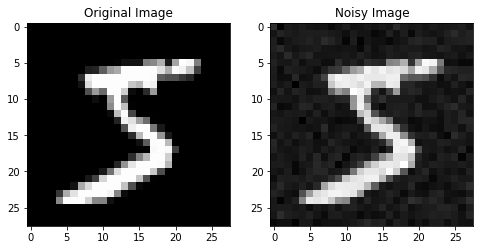

In [4]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1), plt.imshow(X_train[0], 'gray'), plt.title("Original Image")
plt.subplot(1, 2, 2), plt.imshow(noise(X_train[0]), 'gray'), plt.title("Noisy Image")
plt.show()

In [5]:
def generate_noisy_dataset(feature_matrix):
    """
    Generates noisy dataset of images.
    @Param:
    1. feature_matrix: (nd.array) original/clean images.
    @Returns:
    - noisy_data: dirty/noisy images after applying gaussian noise function.
    """
    noisy_data = []
    for img in feature_matrix:
        noisy_data.append(noise(img))
    return np.array(noisy_data).reshape(feature_matrix.shape)

In [6]:
noisy_X_train = generate_noisy_dataset(X_train)
noisy_X_test = generate_noisy_dataset(X_test)

In [7]:
class Dataset(Dataset):
    """Generate dataset from feature_matrix and labels"""
    def __init__(self, noisy_data, original_data, labels, transform):
        """Gather data"""
        self.dirty = noisy_data
        self.clean = original_data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        """Overrride default len to call shape of noisy_dataset"""
        return len(self.dirty)
    
    def __getitem__(self, i):
        """Get an item from noisy dataset at index, i"""
        x_noisy = self.dirty[i]
        x_clean = self.clean[i]
        y_label = self.labels[i]
        
        #check for transform
        if(self.transform is not None):
            x_noisy = self.transform(x_noisy)
            x_clean = self.transform(x_clean)
        
        return x_noisy, x_clean, y_label

In [8]:
tsfms = transforms.Compose([transforms.ToTensor()]) #get transform
#load data
trainset = Dataset(noisy_X_train, X_train, y_train, tsfms)
testset  = Dataset(noisy_X_test, X_test, y_test, tsfms)

In [9]:
#load data into batches
trainloader = DataLoader(trainset,batch_size=32, shuffle=True) #mini-batch of 32
testloader = DataLoader(testset,batch_size=1, shuffle=True)

## Step 3. Autoencoder model

In [10]:
class DAE(nn.Module):
    """Defines the Denoising Autoencoder model"""
    def __init__(self, image_size=(28, 28), fc1=256, fc2=128, bottleneck=64):
        """
        Initialize encoder and decoder model.
        @Param: 
        1. image_size: height and width of input image, tuple (m, n), where m is height and n is width.
        2. fc1: number of hidden units for first fully connected layer.
        3. fc2: number of hidden units for second fully connected layer.
        4. bottleneck: number of hidden units for bottleneck (codes) layer.
        """
        super(DAE, self).__init__()
        m, n = image_size
        self.encoder = nn.Sequential(
                  nn.Linear(m * n, fc1),
                  nn.ReLU(True),
                  nn.Linear(fc1, fc2),
                  nn.ReLU(True),
                  nn.Linear(fc2, bottleneck),
                  nn.ReLU(True)
                  )
        #build decoder as reconstruction filter.
        self.decoder = nn.Sequential(
                      nn.Linear(bottleneck, fc2),
                      nn.ReLU(True),
                      nn.Linear(fc2, fc1),
                      nn.ReLU(True),
                      nn.Linear(fc1, m * n),
                      nn.Sigmoid(),
                      )
        
    def forward(self, x):
        """Override forward pass by incorporating encoder and decoder network architecture"""
        x = self.encoder(x) #compress image
        x = self.decoder(x) #reconstruction
        return x

In [11]:
#Enable cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
model = DAE()
# according to paper, lossy image compression with compressive autoencoders (https://arxiv.org/pdf/1703.00395.pdf)
# they used MSE loss as a measure of distortion b/w reconstruction and original image
### Note that original image ≠ input image.
loss = nn.MSELoss()
# paper uses Adam optimizer for regularization with default Adam hyperparameters. keeping it as is for now.
optimizer = optim.Adam(model.parameters())

## Step 4. Training the model

In [13]:
def train(feature_matrix, epochs=int(2e2), epsilon=0.5):
    """
    Trains Autoencoder based on noisy images and corresponding labels
    @Param:
    1. feature_matrix: (nd.array) tuple representing (noisy_images, original_images).
    2. epochs: (int) number of iterations
    3. epsilon: (float) stopping condition
    """
    cost = []
    for epoch in range(epochs):
        running_loss = 0
        
        temp = round(cost[-1], 5) if len(cost) > 0 else None
        print(r"Epoch : " + str(epoch + 1) + "; Loss = " + str(temp), end="")
        
        for dirty, clean, label in tqdm((feature_matrix)):
            dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).to(device)
            clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).to(device)
            
            output = model(dirty) #get output from forward pass.
            loss_output = loss(output, clean) #generate MSE error
            
            optimizer.zero_grad() #clean gradients
            loss_output.backward() #backprop
            optimizer.step()
            
            running_loss += loss_output.item()
        
        #append costs
        cost.append(running_loss)
        
        if(running_loss < epsilon):
            break

    return cost

In [14]:
cost = train(trainloader)

  2%|▏         | 44/1875 [00:00<00:08, 213.35it/s]

Epoch : 1; Loss = None

  1%|          | 12/1875 [00:00<00:16, 116.23it/s]

Epoch : 2; Loss = 38.55791

  1%|          | 12/1875 [00:00<00:15, 116.51it/s]

Epoch : 3; Loss = 21.75985

  1%|          | 10/1875 [00:00<00:19, 94.70it/s]

Epoch : 4; Loss = 18.7331

  1%|          | 11/1875 [00:00<00:18, 103.15it/s]

Epoch : 5; Loss = 17.23593

  1%|          | 13/1875 [00:00<00:15, 119.92it/s]

Epoch : 6; Loss = 16.21222

  1%|          | 12/1875 [00:00<00:16, 115.51it/s]

Epoch : 7; Loss = 15.50767

  1%|          | 13/1875 [00:00<00:15, 121.77it/s]

Epoch : 8; Loss = 15.00166

  1%|          | 12/1875 [00:00<00:15, 118.32it/s]

Epoch : 9; Loss = 14.59848

  1%|          | 13/1875 [00:00<00:15, 124.00it/s]

Epoch : 10; Loss = 14.35703

  1%|          | 13/1875 [00:00<00:14, 125.15it/s]

Epoch : 11; Loss = 14.03778

  1%|          | 13/1875 [00:00<00:14, 128.70it/s]

Epoch : 12; Loss = 13.85236

  1%|          | 11/1875 [00:00<00:17, 105.54it/s]

Epoch : 13; Loss = 13.67472

  1%|          | 12/1875 [00:00<00:15, 119.70it/s]

Epoch : 14; Loss = 13.51205

  1%|          | 12/1875 [00:00<00:16, 115.69it/s]

Epoch : 15; Loss = 13.3492

  1%|          | 13/1875 [00:00<00:15, 118.50it/s]

Epoch : 16; Loss = 13.21908

  1%|          | 13/1875 [00:00<00:15, 121.66it/s]

Epoch : 17; Loss = 13.11714

  1%|          | 12/1875 [00:00<00:16, 112.29it/s]

Epoch : 18; Loss = 13.00972

  1%|          | 11/1875 [00:00<00:18, 101.21it/s]

Epoch : 19; Loss = 12.84628

  1%|          | 12/1875 [00:00<00:16, 114.65it/s]

Epoch : 20; Loss = 12.85169

  1%|          | 11/1875 [00:00<00:18, 101.43it/s]

Epoch : 21; Loss = 12.68665

  1%|          | 12/1875 [00:00<00:16, 112.50it/s]

Epoch : 22; Loss = 12.62797

  1%|          | 11/1875 [00:00<00:17, 108.63it/s]

Epoch : 23; Loss = 12.58541

  1%|          | 12/1875 [00:00<00:16, 112.77it/s]

Epoch : 24; Loss = 12.47528

  1%|          | 11/1875 [00:00<00:17, 106.76it/s]

Epoch : 25; Loss = 12.44898

  1%|          | 12/1875 [00:00<00:16, 112.48it/s]

Epoch : 26; Loss = 12.35761

  1%|          | 11/1875 [00:00<00:16, 109.75it/s]

Epoch : 27; Loss = 12.29683

  1%|          | 12/1875 [00:00<00:16, 110.87it/s]

Epoch : 28; Loss = 12.29364

  1%|          | 11/1875 [00:00<00:17, 106.03it/s]

Epoch : 29; Loss = 12.18303

  0%|          | 8/1875 [00:00<00:26, 71.60it/s]

Epoch : 30; Loss = 12.2384

  1%|          | 10/1875 [00:00<00:19, 93.29it/s]

Epoch : 31; Loss = 12.07413

  1%|          | 10/1875 [00:00<00:20, 92.96it/s]

Epoch : 32; Loss = 12.13778

  0%|          | 9/1875 [00:00<00:21, 85.25it/s]

Epoch : 33; Loss = 12.03782

  0%|          | 9/1875 [00:00<00:22, 82.29it/s]

Epoch : 34; Loss = 12.02929

  0%|          | 9/1875 [00:00<00:23, 80.87it/s]

Epoch : 35; Loss = 11.98262

  0%|          | 9/1875 [00:00<00:23, 81.01it/s]

Epoch : 36; Loss = 11.91534

  0%|          | 8/1875 [00:00<00:24, 76.99it/s]

Epoch : 37; Loss = 12.01067

  0%|          | 8/1875 [00:00<00:24, 76.34it/s]

Epoch : 38; Loss = 11.88665

  0%|          | 8/1875 [00:00<00:24, 74.95it/s]

Epoch : 39; Loss = 11.86266

  0%|          | 8/1875 [00:00<00:24, 75.55it/s]

Epoch : 40; Loss = 11.84506

  0%|          | 8/1875 [00:00<00:23, 78.25it/s]

Epoch : 41; Loss = 11.86403

  0%|          | 9/1875 [00:00<00:23, 80.86it/s]

Epoch : 42; Loss = 11.77666

  0%|          | 8/1875 [00:00<00:24, 77.61it/s]

Epoch : 43; Loss = 11.80236

  0%|          | 8/1875 [00:00<00:24, 77.72it/s]

Epoch : 44; Loss = 11.7879

  0%|          | 8/1875 [00:00<00:23, 79.29it/s]

Epoch : 45; Loss = 11.70497

  0%|          | 8/1875 [00:00<00:25, 74.01it/s]

Epoch : 46; Loss = 11.7046

  0%|          | 8/1875 [00:00<00:24, 77.63it/s]

Epoch : 47; Loss = 11.7237

  0%|          | 8/1875 [00:00<00:24, 77.03it/s]

Epoch : 48; Loss = 11.68305

  0%|          | 8/1875 [00:00<00:24, 75.38it/s]

Epoch : 49; Loss = 11.64015

  0%|          | 8/1875 [00:00<00:24, 76.33it/s]

Epoch : 50; Loss = 11.65626

  0%|          | 8/1875 [00:00<00:25, 74.07it/s]

Epoch : 51; Loss = 11.66799

  0%|          | 8/1875 [00:00<00:24, 74.75it/s]

Epoch : 52; Loss = 11.61657

  0%|          | 8/1875 [00:00<00:24, 75.19it/s]

Epoch : 53; Loss = 11.60856

  0%|          | 8/1875 [00:00<00:24, 75.27it/s]

Epoch : 54; Loss = 11.61798

  0%|          | 8/1875 [00:00<00:25, 73.53it/s]

Epoch : 55; Loss = 11.61017

  0%|          | 8/1875 [00:00<00:25, 74.57it/s]

Epoch : 56; Loss = 11.57587

  0%|          | 7/1875 [00:00<00:27, 67.50it/s]

Epoch : 57; Loss = 11.61156

  0%|          | 8/1875 [00:00<00:24, 74.89it/s]

Epoch : 58; Loss = 11.48294

  0%|          | 8/1875 [00:00<00:24, 76.28it/s]

Epoch : 59; Loss = 11.51597

  0%|          | 8/1875 [00:00<00:24, 75.35it/s]

Epoch : 60; Loss = 11.55479

  0%|          | 8/1875 [00:00<00:25, 74.17it/s]

Epoch : 61; Loss = 11.47025

  0%|          | 8/1875 [00:00<00:24, 75.37it/s]

Epoch : 62; Loss = 11.4771

  0%|          | 8/1875 [00:00<00:26, 71.80it/s]

Epoch : 63; Loss = 11.50821

  0%|          | 8/1875 [00:00<00:24, 74.75it/s]

Epoch : 64; Loss = 11.4779

  0%|          | 7/1875 [00:00<00:26, 69.62it/s]

Epoch : 65; Loss = 11.45196

  0%|          | 8/1875 [00:00<00:25, 73.08it/s]

Epoch : 66; Loss = 11.47078

  0%|          | 8/1875 [00:00<00:24, 75.67it/s]

Epoch : 67; Loss = 11.46921

  0%|          | 8/1875 [00:00<00:25, 74.18it/s]

Epoch : 68; Loss = 11.40332

  0%|          | 7/1875 [00:00<00:29, 63.64it/s]

Epoch : 69; Loss = 11.47575

  0%|          | 8/1875 [00:00<00:25, 73.68it/s]

Epoch : 70; Loss = 11.38923

  0%|          | 8/1875 [00:00<00:24, 75.93it/s]

Epoch : 71; Loss = 11.39316

  0%|          | 8/1875 [00:00<00:25, 74.30it/s]

Epoch : 72; Loss = 11.3658

  0%|          | 8/1875 [00:00<00:25, 72.80it/s]

Epoch : 73; Loss = 11.41684

  0%|          | 8/1875 [00:00<00:25, 74.11it/s]

Epoch : 74; Loss = 11.35034

  0%|          | 8/1875 [00:00<00:25, 72.52it/s]

Epoch : 75; Loss = 11.36566

  0%|          | 8/1875 [00:00<00:24, 75.61it/s]

Epoch : 76; Loss = 11.36386

  0%|          | 8/1875 [00:00<00:24, 76.45it/s]

Epoch : 77; Loss = 11.32449

  0%|          | 8/1875 [00:00<00:26, 71.19it/s]

Epoch : 78; Loss = 11.35687

  0%|          | 8/1875 [00:00<00:25, 73.86it/s]

Epoch : 79; Loss = 11.3244

  0%|          | 8/1875 [00:00<00:25, 72.72it/s]

Epoch : 80; Loss = 11.26578

  0%|          | 8/1875 [00:00<00:25, 72.91it/s]

Epoch : 81; Loss = 11.36722

  0%|          | 8/1875 [00:00<00:26, 71.58it/s]

Epoch : 82; Loss = 11.26446

  0%|          | 8/1875 [00:00<00:25, 73.37it/s]

Epoch : 83; Loss = 11.34576

  0%|          | 8/1875 [00:00<00:25, 72.25it/s]

Epoch : 84; Loss = 11.25803

  0%|          | 8/1875 [00:00<00:25, 71.90it/s]

Epoch : 85; Loss = 11.33692

  0%|          | 8/1875 [00:00<00:25, 72.72it/s]

Epoch : 86; Loss = 11.30445

  0%|          | 8/1875 [00:00<00:26, 71.76it/s]

Epoch : 87; Loss = 11.32299

  0%|          | 7/1875 [00:00<00:26, 69.30it/s]

Epoch : 88; Loss = 11.29238

  0%|          | 7/1875 [00:00<00:26, 69.64it/s]

Epoch : 89; Loss = 11.30376

  0%|          | 8/1875 [00:00<00:26, 71.76it/s]

Epoch : 90; Loss = 11.28657

  0%|          | 8/1875 [00:00<00:25, 73.97it/s]

Epoch : 91; Loss = 11.26356

  0%|          | 8/1875 [00:00<00:26, 70.32it/s]

Epoch : 92; Loss = 11.2687

  0%|          | 8/1875 [00:00<00:26, 71.35it/s]

Epoch : 93; Loss = 11.30915

  0%|          | 8/1875 [00:00<00:25, 72.17it/s]

Epoch : 94; Loss = 11.27832

  0%|          | 8/1875 [00:00<00:25, 72.41it/s]

Epoch : 95; Loss = 11.26426

  0%|          | 8/1875 [00:00<00:26, 71.16it/s]

Epoch : 96; Loss = 11.21978

  0%|          | 8/1875 [00:00<00:26, 70.53it/s]

Epoch : 97; Loss = 11.26205

  0%|          | 7/1875 [00:00<00:27, 68.99it/s]

Epoch : 98; Loss = 11.24513

  0%|          | 7/1875 [00:00<00:27, 69.01it/s]

Epoch : 99; Loss = 11.23318

  0%|          | 8/1875 [00:00<00:25, 73.91it/s]

Epoch : 100; Loss = 11.26085

  0%|          | 7/1875 [00:00<00:27, 68.04it/s]

Epoch : 101; Loss = 11.20612

  0%|          | 7/1875 [00:00<00:27, 68.19it/s]

Epoch : 102; Loss = 11.25382

  0%|          | 8/1875 [00:00<00:25, 73.45it/s]

Epoch : 103; Loss = 11.20957

  0%|          | 8/1875 [00:00<00:25, 72.43it/s]

Epoch : 104; Loss = 11.23519

  0%|          | 8/1875 [00:00<00:25, 72.46it/s]

Epoch : 105; Loss = 11.15069

  0%|          | 8/1875 [00:00<00:25, 73.56it/s]

Epoch : 106; Loss = 11.27536

  0%|          | 8/1875 [00:00<00:26, 71.35it/s]

Epoch : 107; Loss = 11.21905

  0%|          | 7/1875 [00:00<00:27, 69.06it/s]

Epoch : 108; Loss = 11.209

  0%|          | 8/1875 [00:00<00:26, 70.79it/s]

Epoch : 109; Loss = 11.21479

  0%|          | 7/1875 [00:00<00:27, 69.06it/s]

Epoch : 110; Loss = 11.22933

  0%|          | 7/1875 [00:00<00:27, 68.71it/s]

Epoch : 111; Loss = 11.16295

  0%|          | 7/1875 [00:00<00:27, 67.53it/s]

Epoch : 112; Loss = 11.2046

  0%|          | 7/1875 [00:00<00:26, 69.65it/s]

Epoch : 113; Loss = 11.16146

  0%|          | 7/1875 [00:00<00:27, 68.57it/s]

Epoch : 114; Loss = 11.21038

  0%|          | 7/1875 [00:00<00:27, 67.79it/s]

Epoch : 115; Loss = 11.16956

  0%|          | 7/1875 [00:00<00:27, 67.86it/s]

Epoch : 116; Loss = 11.18245

  0%|          | 7/1875 [00:00<00:27, 68.60it/s]

Epoch : 117; Loss = 11.17556

  0%|          | 7/1875 [00:00<00:26, 69.81it/s]

Epoch : 118; Loss = 11.18287

  0%|          | 7/1875 [00:00<00:26, 69.78it/s]

Epoch : 119; Loss = 11.19047

  0%|          | 7/1875 [00:00<00:26, 69.24it/s]

Epoch : 120; Loss = 11.18977

  0%|          | 8/1875 [00:00<00:26, 70.66it/s]

Epoch : 121; Loss = 11.158

  0%|          | 7/1875 [00:00<00:27, 68.49it/s]

Epoch : 122; Loss = 11.16033

  0%|          | 8/1875 [00:00<00:26, 71.18it/s]

Epoch : 123; Loss = 11.16495

  0%|          | 7/1875 [00:00<00:29, 63.94it/s]

Epoch : 124; Loss = 11.16681

  0%|          | 8/1875 [00:00<00:26, 71.60it/s]

Epoch : 125; Loss = 11.19377

  1%|          | 14/1875 [00:00<00:27, 68.78it/s]

Epoch : 126; Loss = 11.13167

  0%|          | 7/1875 [00:00<00:27, 67.48it/s]

Epoch : 127; Loss = 11.15607

  0%|          | 7/1875 [00:00<00:27, 69.06it/s]

Epoch : 128; Loss = 11.14132

  0%|          | 8/1875 [00:00<00:25, 71.98it/s]

Epoch : 129; Loss = 11.17203

  0%|          | 8/1875 [00:00<00:26, 70.98it/s]

Epoch : 130; Loss = 11.11423

  0%|          | 8/1875 [00:00<00:26, 71.78it/s]

Epoch : 131; Loss = 11.13297

  0%|          | 7/1875 [00:00<00:26, 69.22it/s]

Epoch : 132; Loss = 11.1649

  0%|          | 7/1875 [00:00<00:30, 61.56it/s]

Epoch : 133; Loss = 11.18397

  0%|          | 7/1875 [00:00<00:26, 69.95it/s]

Epoch : 134; Loss = 11.14891

  0%|          | 8/1875 [00:00<00:25, 72.13it/s]

Epoch : 135; Loss = 11.17411

  0%|          | 8/1875 [00:00<00:25, 71.95it/s]

Epoch : 136; Loss = 11.14254

  0%|          | 7/1875 [00:00<00:26, 69.64it/s]

Epoch : 137; Loss = 11.12516

  0%|          | 7/1875 [00:00<00:28, 65.14it/s]

Epoch : 138; Loss = 11.16335

  0%|          | 7/1875 [00:00<00:26, 69.29it/s]

Epoch : 139; Loss = 11.11397

  0%|          | 7/1875 [00:00<00:27, 67.68it/s]

Epoch : 140; Loss = 11.12771

  0%|          | 7/1875 [00:00<00:27, 67.45it/s]

Epoch : 141; Loss = 11.14807

  0%|          | 7/1875 [00:00<00:27, 68.64it/s]

Epoch : 142; Loss = 11.09994

  0%|          | 7/1875 [00:00<00:27, 68.46it/s]

Epoch : 143; Loss = 11.10549

  0%|          | 7/1875 [00:00<00:27, 68.04it/s]

Epoch : 144; Loss = 11.17279

  0%|          | 7/1875 [00:00<00:27, 67.22it/s]

Epoch : 145; Loss = 11.10513

  0%|          | 6/1875 [00:00<00:31, 58.94it/s]

Epoch : 146; Loss = 11.10193

  0%|          | 7/1875 [00:00<00:27, 68.03it/s]

Epoch : 147; Loss = 11.11661

  0%|          | 8/1875 [00:00<00:25, 72.11it/s]

Epoch : 148; Loss = 11.0566

  0%|          | 7/1875 [00:00<00:27, 68.15it/s]

Epoch : 149; Loss = 11.1245

  0%|          | 7/1875 [00:00<00:29, 63.81it/s]

Epoch : 150; Loss = 11.10799

  0%|          | 7/1875 [00:00<00:27, 68.14it/s]

Epoch : 151; Loss = 11.13708

  0%|          | 7/1875 [00:00<00:28, 65.83it/s]

Epoch : 152; Loss = 11.11245

  0%|          | 7/1875 [00:00<00:27, 68.34it/s]

Epoch : 153; Loss = 11.10522

  0%|          | 8/1875 [00:00<00:26, 69.95it/s]

Epoch : 154; Loss = 11.06291

  0%|          | 7/1875 [00:00<00:27, 68.33it/s]

Epoch : 155; Loss = 11.12411

  0%|          | 7/1875 [00:00<00:27, 68.46it/s]

Epoch : 156; Loss = 11.08844

  0%|          | 8/1875 [00:00<00:26, 69.66it/s]

Epoch : 157; Loss = 11.10948

  0%|          | 7/1875 [00:00<00:27, 67.53it/s]

Epoch : 158; Loss = 11.06749

  0%|          | 5/1875 [00:00<00:40, 45.90it/s]

Epoch : 159; Loss = 11.08474

  0%|          | 7/1875 [00:00<00:27, 68.53it/s]

Epoch : 160; Loss = 11.07789

  0%|          | 8/1875 [00:00<00:26, 71.49it/s]

Epoch : 161; Loss = 11.07874

  0%|          | 5/1875 [00:00<00:39, 47.03it/s]

Epoch : 162; Loss = 11.11744

  0%|          | 7/1875 [00:00<00:28, 65.95it/s]

Epoch : 163; Loss = 11.07203

  0%|          | 7/1875 [00:00<00:27, 68.44it/s]

Epoch : 164; Loss = 11.10482

  0%|          | 7/1875 [00:00<00:28, 66.60it/s]

Epoch : 165; Loss = 11.08159

  0%|          | 7/1875 [00:00<00:28, 64.63it/s]

Epoch : 166; Loss = 11.06493

  0%|          | 7/1875 [00:00<00:27, 68.35it/s]

Epoch : 167; Loss = 11.09037

  0%|          | 5/1875 [00:00<00:38, 49.17it/s]

Epoch : 168; Loss = 11.08972

  0%|          | 5/1875 [00:00<00:42, 43.94it/s]

Epoch : 169; Loss = 11.08827

  0%|          | 7/1875 [00:00<00:29, 62.96it/s]

Epoch : 170; Loss = 11.0663

  0%|          | 7/1875 [00:00<00:27, 68.73it/s]

Epoch : 171; Loss = 11.03881

  0%|          | 6/1875 [00:00<00:31, 58.49it/s]

Epoch : 172; Loss = 11.09294

  0%|          | 6/1875 [00:00<00:31, 59.85it/s]

Epoch : 173; Loss = 11.04943

  0%|          | 6/1875 [00:00<00:34, 54.33it/s]

Epoch : 174; Loss = 11.05553

  0%|          | 8/1875 [00:00<00:25, 72.71it/s]

Epoch : 175; Loss = 11.0682

  0%|          | 7/1875 [00:00<00:26, 69.54it/s]

Epoch : 176; Loss = 11.08587

  0%|          | 6/1875 [00:00<00:33, 56.19it/s]

Epoch : 177; Loss = 11.06529

  0%|          | 7/1875 [00:00<00:28, 65.53it/s]

Epoch : 178; Loss = 11.01473

  0%|          | 8/1875 [00:00<00:26, 70.05it/s]

Epoch : 179; Loss = 11.06626

  0%|          | 7/1875 [00:00<00:26, 69.66it/s]

Epoch : 180; Loss = 11.01899

  0%|          | 7/1875 [00:00<00:27, 69.09it/s]

Epoch : 181; Loss = 11.06403

  0%|          | 7/1875 [00:00<00:28, 66.28it/s]

Epoch : 182; Loss = 11.0116

  0%|          | 7/1875 [00:00<00:27, 68.78it/s]

Epoch : 183; Loss = 11.07812

  0%|          | 6/1875 [00:00<00:31, 59.88it/s]

Epoch : 184; Loss = 11.0542

  0%|          | 7/1875 [00:00<00:29, 63.10it/s]

Epoch : 185; Loss = 11.02974

  0%|          | 7/1875 [00:00<00:29, 63.64it/s]

Epoch : 186; Loss = 11.07996

  0%|          | 7/1875 [00:00<00:29, 62.54it/s]

Epoch : 187; Loss = 10.98991

  0%|          | 7/1875 [00:00<00:26, 69.42it/s]

Epoch : 188; Loss = 11.04353

  0%|          | 7/1875 [00:00<00:27, 67.06it/s]

Epoch : 189; Loss = 11.06572

  0%|          | 6/1875 [00:00<00:31, 58.62it/s]

Epoch : 190; Loss = 11.02996

  0%|          | 5/1875 [00:00<00:40, 46.39it/s]

Epoch : 191; Loss = 11.10352

  0%|          | 7/1875 [00:00<00:28, 64.60it/s]

Epoch : 192; Loss = 11.00408

  0%|          | 7/1875 [00:00<00:27, 68.21it/s]

Epoch : 193; Loss = 11.00783

  0%|          | 8/1875 [00:00<00:25, 73.50it/s]

Epoch : 194; Loss = 11.03695

  0%|          | 7/1875 [00:00<00:27, 67.90it/s]

Epoch : 195; Loss = 10.99459

  0%|          | 6/1875 [00:00<00:32, 58.33it/s]

Epoch : 196; Loss = 11.05377

  0%|          | 8/1875 [00:00<00:25, 72.51it/s]

Epoch : 197; Loss = 11.05888

  0%|          | 8/1875 [00:00<00:25, 73.94it/s]

Epoch : 198; Loss = 10.98963

  0%|          | 8/1875 [00:00<00:25, 74.45it/s]

Epoch : 199; Loss = 11.09557

  0%|          | 8/1875 [00:00<00:25, 74.46it/s]

Epoch : 200; Loss = 11.00872

100%|██████████| 1875/1875 [00:26<00:00, 70.66it/s]


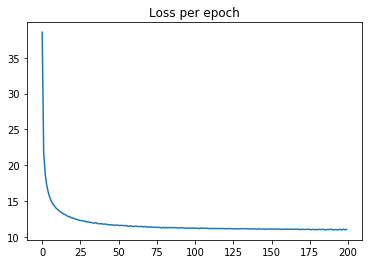

In [15]:
plt.title("Loss per epoch")
plt.plot(cost)
plt.show()

## Step 5. Test model

In [16]:
def test(feature_matrix):
    """Compresses images where feature_matrix represents noisy and original images"""
    noisy, clean = feature_matrix
    
    compressed_images = [] #encoder
    reconstructed_images = [] #autoencoder
    
    total_loss = 0
    for img, c_img in tqdm(zip(noisy, clean)):
        img = torch.from_numpy(img).float().squeeze(0).flatten().to(device)
        c_img = torch.from_numpy(c_img).float().squeeze(0).flatten().to(device)
        
        #get compressed image from encoder part of network
        compressed_output = model.encoder(img)
        
        output = model(img)
        
        loss_output = loss(output, c_img) #generate MSE error
        
        output = output.view(1,28,28)
        output = output.permute(1,2,0).squeeze(2)
        output = output.detach().cpu().numpy()
        reconstructed_images.append(output) #append compressed reconstructed image
        
        
        compressed_output = compressed_output.view(1,8,8)
        compressed_output = compressed_output.permute(1,2,0).squeeze(2)
        compressed_output = compressed_output.detach().cpu().numpy()
        compressed_images.append(compressed_output) #append bottleneck output
        
        total_loss += loss_output.item()
    
    return np.array(compressed_images), np.array(reconstructed_images), total_loss

In [17]:
compressed_images, reconstructed_images, cost = test((noisy_X_test, X_test))

10000it [00:06, 1439.96it/s]


In [18]:
def visualize(original_images, noisy_images, reconstructed_images, compressed_images, N=5):
    """
    Visualization only.
    Displays plots of N random images alongside compressed and original image.
    """
    ## gather random images
    random_images = np.random.randint(0,len(compressed_images), size=N)

    ### display images
    f, axes = plt.subplots(N, 4, figsize=(20, 20))
    axes[0,0].set_title("Original Image")
    axes[0,1].set_title("Noisy Image")
    axes[0,2].set_title("Compressed Image")
    axes[0,3].set_title("Reconstructed Image")
    
    for i in range(N):
        c = compressed_images[random_images[i]] #compressed image
        o = original_images[random_images[i]] #original image
        r = reconstructed_images[random_images[i]] #reconstructed image
        n = noisy_images[random_images[i]] #noisy image
        
        axes[i, 0].imshow(o, cmap="gray") #DISPLAY ORIGINAL IMAGE
        axes[i, 1].imshow(n, cmap="gray") #DISPLAY NOISY IMAGE
        axes[i, 2].imshow(c, cmap="gray") #DISPLAY COMPRESSED IMAGE
        axes[i, 3].imshow(r, cmap="gray") #DISPLAY RECONSTRUCTED IMAGE
        
    
    # remove the x and y ticks
    loc = tkt.NullLocator()

    for ax in axes:
        for x in ax:
            x.yaxis.set_major_locator(loc)
            x.xaxis.set_major_locator(loc)
        
    plt.show()

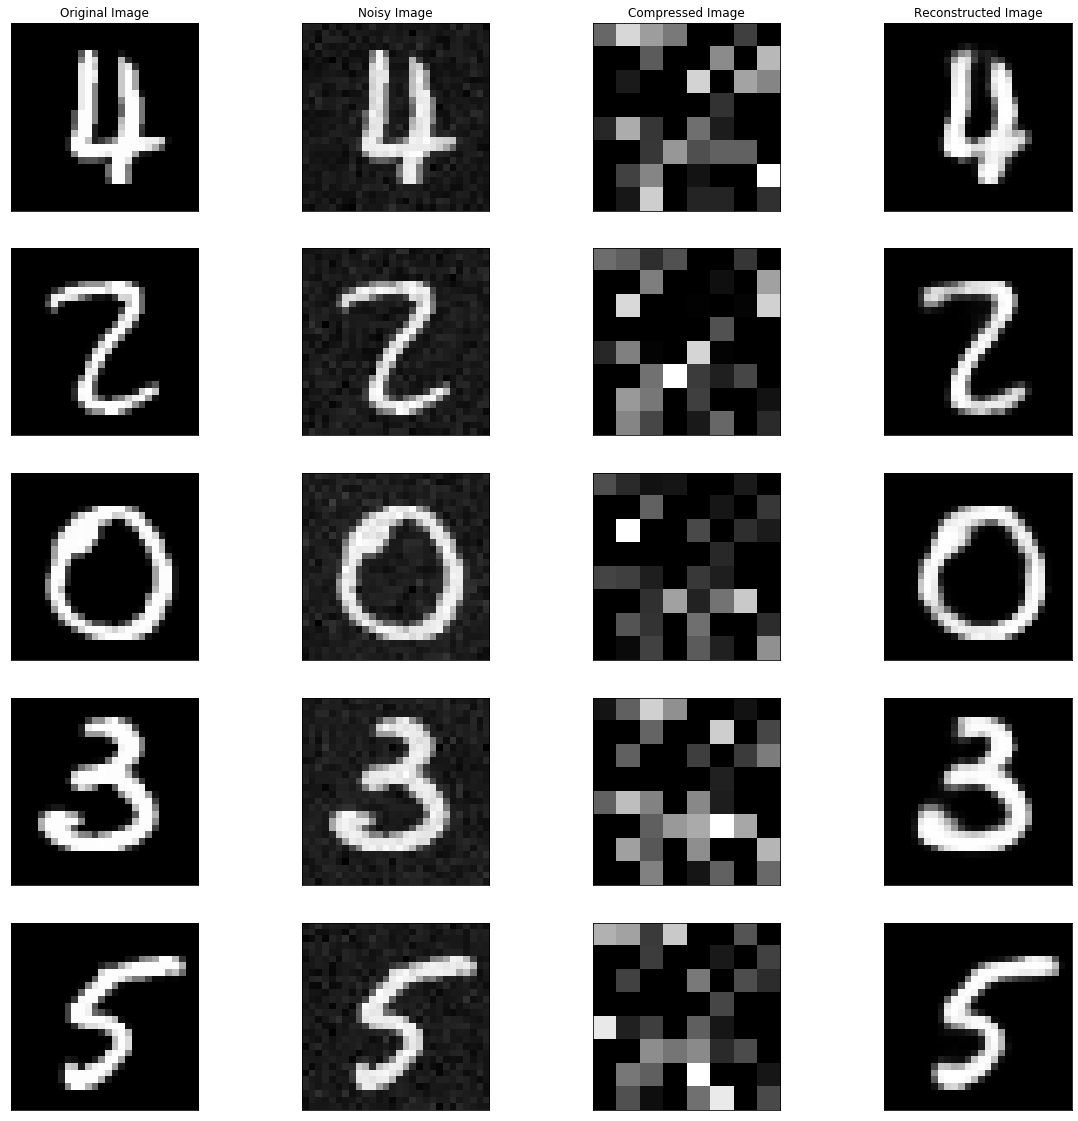

In [19]:
visualize(X_test, noisy_X_test, reconstructed_images, compressed_images) #visualize output

## Test any image

In [20]:
def compress_image(img):
    """
    Compress an image using Deep Denoising Compressive Autoencoder
    """
    if(type(img) == str): #load image first
        img = 255*rgb2gray(np.array(cv2.imread(img)))
    
    #resize to 28x28
    img = cv2.resize(img, (28, 28), interpolation = cv2.INTER_AREA)
    
    #convert to tensor
    output = torch.from_numpy(noise(img)).float().squeeze(0).flatten().to(device)
    
    output = model(output)
    
    #convert back to nd.array
    output = output.view(1,28,28)
    output = output.permute(1,2,0).squeeze(2)
    output = output.detach().cpu().numpy()
    
    return img.reshape(28, 28), output #return original and compressed images

In [21]:
test_original, test_compressed = compress_image(X_test[100])

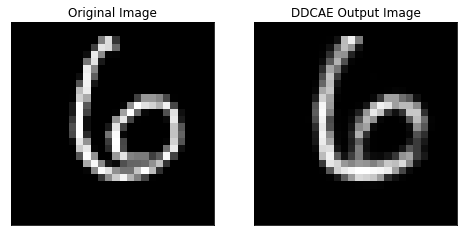

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1), plt.imshow(test_original, 'gray')
plt.title("Original Image")
plt.xticks([]), plt.yticks([]) #remove x and y axis

plt.subplot(1, 2, 2), plt.imshow(test_compressed, 'gray')
plt.title("DDCAE Output Image")
plt.xticks([]), plt.yticks([]) #remove x and y axis

plt.show()

## Save model

In [23]:
torch.save(model.state_dict(), "../model/ddcae_2.pth") #save model.